In [72]:
import matplotlib.pyplot as plt
import skimage.io as io

from models.models import *
from models.UNet import UNet2D

import torch
from skimage import graph, data, io, segmentation, color, filters
from skimage.measure import regionprops
from skimage import draw
from skimage.segmentation import relabel_sequential
import numpy as np
from random import shuffle
import skimage.future.graph as graph

from super_pixel import RAG
from environment import *

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utility funcs

In [4]:
def show_img(img, size=5):
    f = plt.figure(figsize=(size, size))
    plt.imshow(img)

def gray2rgb (img):
    return np.repeat (np.expand_dims (img, -1), 3, -1)
    
def gridize (img, dx, dy):

    # Custom (rgb) grid color
    grid_color = [0,255,255]
    img = np.copy (img)
    # Modify the image to include the grid
    img[:,::dy,:] = grid_color
    img[::dx,:,:] = grid_color
    return img

import colorsys

def color_generator (N):
    HSV_tuples = [(x*1.0/N, 0.5, (x%8)*0.07 + 0.5) for x in range(N)]
    RGB_tuples = list (map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

    COLOR_LIST = [(int (rgb[0] * 255), int (rgb[1] * 255), int (rgb[2] * 255)) for rgb in RGB_tuples]
    shuffle (COLOR_LIST)
    COLOR_LIST [0] = (0, 0, 0)

    def index2rgb (index):
        return COLOR_LIST [index]
    def lbl2rgb (lbl):
        original_shape = np.squeeze (lbl).shape
        lbl = lbl.flatten ().tolist ()
        lbl = list (map (index2rgb, lbl))
        lbl = np.array (lbl).reshape (original_shape + (3,))
        return lbl
    return lbl2rgb

color_g = color_generator (3000)

def display_edges(image, edges, threshold, rag):
    """Draw edges of a RAG on its image
 
    Returns a modified image with the edges drawn.Edges are drawn in green
    and nodes are drawn in yellow.
 
    Parameters
    ----------
    image : ndarray
        The image to be drawn on.
    edges : edges
        The Region Adjacency Graph.
    threshold : float
        Only edges in `g` below `threshold` are drawn.
    rag : RAG
        graph information
 
    Returns:
    out: ndarray
        Image with the edges drawn.
    """
    image = image.copy()
    for edge in edges:
        n1, n2 = edge
 
        r1, c1 = map(int, rag.nodes[n1]['centroid'])
        r2, c2 = map(int, rag.nodes[n2]['centroid'])
 
        line  = draw.line(r1, c1, r2, c2)
        circle = draw.circle(r1,c1,1)
 
        image[line] = 0,1,0
        image[circle] = 1,1,0
 
    return image

def display_bbox (img, g):
    img = np.copy (img)
    for node in g.nodes:
        if np.random.rand () < 0.7:
            continue
        node = g.nodes [node]
        r0, c0, r1, c1 = node ["bbox"]
        r1 = min (254, r1)
        c1 = min (254, c1)
        box = draw.rectangle_perimeter ((r0,c0), (r1,c1))
        img [box] = 0,1,1
    return img

# Read data

In [5]:
img = io.imread ("Data/Cremi/Corrected/256/train/A/A_0.tif")
lbl = relabel_sequential (io.imread ("Data/Cremi/Corrected/256/train/B/B_0.tif")) [0] .astype (np.int32)
lbl_rgb = color_g (lbl + 1)
lbl += 1

# Args and global vars

In [25]:
class aux ():
    def __init__ (self):
        pass


image = img
label = lbl
n_segments=1024
compactness=0.0001

config = {
    'T': 3,
    'size': [256, 256],
    'base': 2,
    '3D': False,
    'n_segments': 1024,
    'data_chan': 1,
    'split_r': 2,
    'spl_w': 2,
    'mer_w': 1,
}

raw_list = [image]
isTrain = True
gt_lbl_list = [label]


# Generate Env

In [159]:
env = EM_env (config, raw_list, gt_lbl_list, isTrain)

{'T': 3, 'size': [256, 256], 'base': 2, '3D': False, 'n_segments': 1024, 'data_chan': 1, 'split_r': 2, 'spl_w': 2, 'mer_w': 1}


In [160]:
obs = env.reset ()

In [161]:
visual = env.visualize ()

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


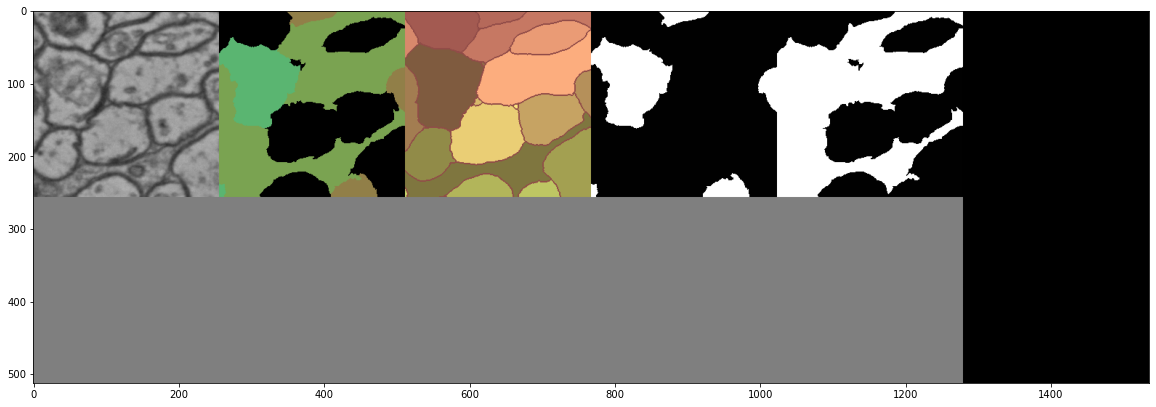

In [163]:
show_img (visual, 20)

In [162]:
for arr in obs:
    print (np.min (arr), np.max (arr))

0.13333333333333333 0.7215686274509804
0.0 1.0
-1.0 1.0
-1.0 1.0
0.0 0.0


1.0 0.0


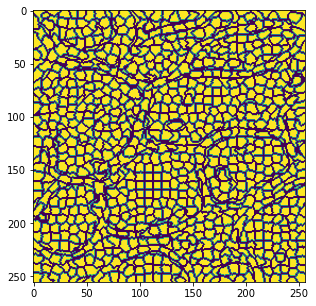

In [147]:
show_img (env.rag.boundary_map)
print (np.max (env.rag.boundary_map), np.min(env.rag.boundary_map))